In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient


In [2]:
from common import (
    sensor_types, sensor_type_mapping,
    get_influx_client
)


# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

# 센서 타입 필터 생성
sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])

# Flux 쿼리 작성
flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)

if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"})
df = df.set_index("time")

# 데이터 확인
print("데이터 샘플:")
display(df.head())
print(f"데이터 크기: {df.shape}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "co2" or r["type"] == "distance" or r["type"] == "humidity" or r["type"] == "illumination" or r["type"] == "infrared" or r["type"] == "pressure" or r["type"] == "temperature" or r["type"] == "infrared_and_visible" or r["type"] == "occupancy" or r["type"] == "battery_level" or r["type"] == "activity" or r["type"] == "battery")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnin

데이터 샘플:


,index,result,table,_start,_stop,_value,_field,_measurement,location,type
time,,,,,,,,,,
2025-04-24 01:50:00+00:00,0,mean,0,2025-04-23 08:00:27.168674+00:00,2025-04-24 08:00:27.168674+00:00,32.0,value,sensor,2,battery
2025-04-24 01:55:00+00:00,1,mean,0,2025-04-23 08:00:27.168674+00:00,2025-04-24 08:00:27.168674+00:00,32.0,value,sensor,2,battery
2025-04-24 02:00:00+00:00,2,mean,0,2025-04-23 08:00:27.168674+00:00,2025-04-24 08:00:27.168674+00:00,32.0,value,sensor,2,battery
2025-04-24 02:05:00+00:00,3,mean,0,2025-04-23 08:00:27.168674+00:00,2025-04-24 08:00:27.168674+00:00,32.0,value,sensor,2,battery
2025-04-24 02:10:00+00:00,4,mean,0,2025-04-23 08:00:27.168674+00:00,2025-04-24 08:00:27.168674+00:00,32.0,value,sensor,2,battery


데이터 크기: (1697, 10)


In [3]:
df = df[df["location"]!="냉장고 내부"]

In [4]:
# 4. 불쾌지수 계산 및 해석 함수
def calculate_discomfort_index(temp, humidity):
    """온도와 습도를 기반으로 불쾌지수 계산"""
    return 0.81 * temp + 0.01 * humidity * (0.99 * temp - 14.3) + 46.3

def interpret_discomfort_index(index):
    if index < 70:
        return "쾌적함"
    elif index < 75:
        return "약간 불쾌함"
    elif index < 80:
        return "불쾌함"
    else:
        return "매우 불쾌함"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1669 entries, 2025-04-24 01:50:00+00:00 to 2025-04-24 07:55:00+00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   index         1669 non-null   int64              
 1   result        1669 non-null   object             
 2   table         1669 non-null   int64              
 3   _start        1669 non-null   datetime64[ns, UTC]
 4   _stop         1669 non-null   datetime64[ns, UTC]
 5   _value        1669 non-null   float64            
 6   _field        1669 non-null   object             
 7   _measurement  1669 non-null   object             
 8   location      1669 non-null   object             
 9   type          1669 non-null   object             
dtypes: datetime64[ns, UTC](2), float64(1), int64(2), object(5)
memory usage: 143.4+ KB


위치별 불쾌지수 통계:
               mean        min        max
location                                 
2               NaN        NaN        NaN
8인 책상     70.189301  69.731330  71.240913
보드        71.611932  71.231205  71.720224
스마트팜            NaN        NaN        NaN
안쪽 분리벽    68.978585  68.732635  69.243775
안쪽벽 중앙    69.942032  68.699660  71.688090
왼쪽 뒤      70.901906  69.837677  71.667780
입구        59.619955  51.985075  63.671758
정수기 위     69.765775  69.272847  70.901110
출입문             NaN        NaN        NaN


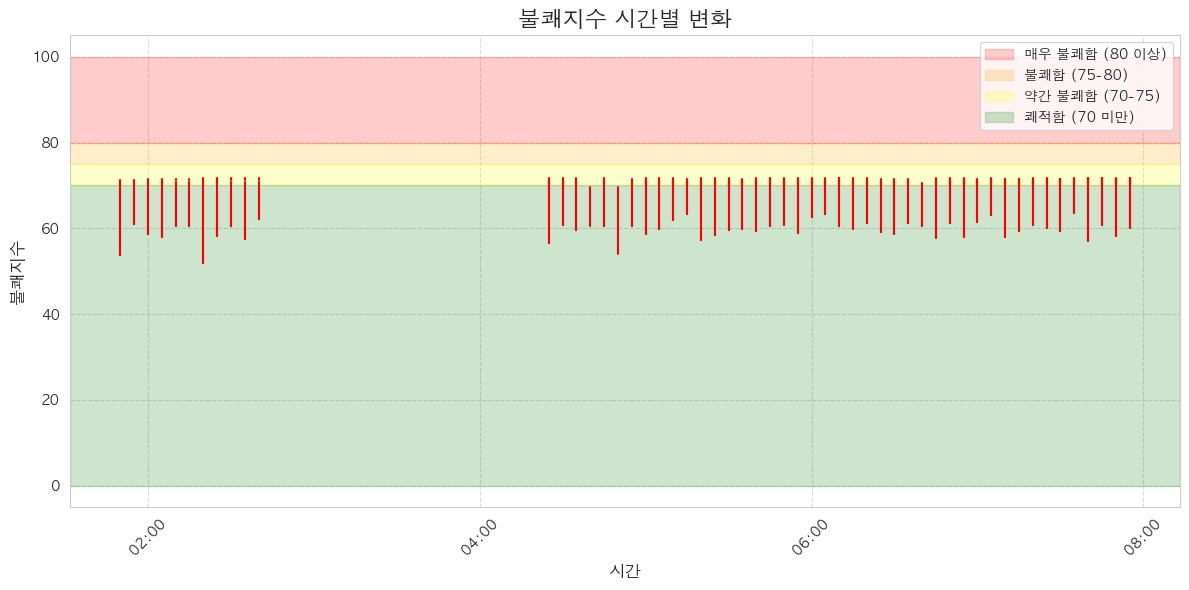

In [6]:
# 1. 데이터 필터링 - 온도와 습도 데이터만 추출
temp_data = df[df['type'] == 'temperature'].copy()
humidity_data = df[df['type'] == 'humidity'].copy()

# 2. 피벗 테이블 생성 방식으로 변경 (더 효율적인 방법)
# 각 센서 타입별로 별도 컬럼 생성
pivot_df = df.pivot_table(
    index=['time', 'location'],  # 시간과 위치로 그룹화
    columns='type',
    values='_value'
).reset_index()

# 인덱스 재설정
pivot_df = pivot_df.set_index('time')

# 온도와 습도 데이터가 있는 경우에만 불쾌지수 계산
if 'temperature' in pivot_df.columns and 'humidity' in pivot_df.columns:
    pivot_df['discomfort_index'] = calculate_discomfort_index(
        pivot_df['temperature'], 
        pivot_df['humidity']
    )
    
    pivot_df['comfort_level'] = pivot_df['discomfort_index'].apply(interpret_discomfort_index)
    
    location_analysis = pivot_df.groupby('location')['discomfort_index'].agg(['mean', 'min', 'max'])
    print("위치별 불쾌지수 통계:")
    print(location_analysis)
    
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import os
    
    # 디렉토리 생성
    os.makedirs('img', exist_ok=True)
    
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df.index, pivot_df['discomfort_index'], 'r-')
    plt.title('불쾌지수 시간별 변화', fontsize=16)
    plt.xlabel('시간', fontsize=12)
    plt.ylabel('불쾌지수', fontsize=12)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.xticks(rotation=45)
    
    plt.axhspan(80, 100, alpha=0.2, color='red', label='매우 불쾌함 (80 이상)')
    plt.axhspan(75, 80, alpha=0.2, color='orange', label='불쾌함 (75-80)')
    plt.axhspan(70, 75, alpha=0.2, color='yellow', label='약간 불쾌함 (70-75)')
    plt.axhspan(0, 70, alpha=0.2, color='green', label='쾌적함 (70 미만)')
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('img/불쾌지수_분석.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("온도 또는 습도 데이터가 없어 불쾌지수를 계산할 수 없습니다.")
